# Stock Market Prediction using CNN-LSTM model
This project is about analysis of Stock Market and providing predictions to the stockholders. 

For this, we used CNN-LSTM approach to create a blank model, then use it to train on stock market data. Further implementation is discussed below...

# Data collect

Before preprocessing data, a function to fetch real-time stock data (using Alpha Vantage API) is made

In [145]:

key = "TV1WC9ANR799K1H1"

import requests
import csv
from tqdm import tqdm
import pandas as pd
def request_stock_price_list(symbol, size, token):
    q_string = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}&outputsize={}&apikey={}'
    proxies = {
        "http": "http://127.0.0.1:7890",
        "https": "http://127.0.0.1:7890",
    }
    print("Retrieving stock price data from Alpha Vantage (This may take a while)...")
    r = requests.get(q_string.format(symbol, size, token), proxies=proxies)
    print("Data has been successfully downloaded...")
    date = []
    colnames = list(range(0, 5))
    df = pd.DataFrame(columns = colnames)
    print("Sorting the retrieved data into a dataframe...")
    for i in tqdm(r.json()['Time Series (Daily)'].keys()):
        date.append(i)
        row = pd.DataFrame.from_dict(r.json()['Time Series (Daily)'][i], orient='index').reset_index().T[1:]
        df = pd.concat([df, row], ignore_index=True)
    df.columns = ["Open", "High", "Low", "Close", "Volume"]
    df['Date'] = date
    return df

In [146]:
# cv1 = request_stock_price_list('600104.SHH', 'full', key)
# print(cv1.head)
# cv1.to_csv('./data/data_SHH.csv')

In [147]:
# cv1 = request_stock_price_list('000002.SHZ', 'full', key)
# print(cv1.head)
# cv1.to_csv('./data/data_SHZ.csv')

In [148]:
# cv1 = request_stock_price_list('TSCO.LON', 'full', key)
# print(cv1.head)
# cv1.to_csv('./data/data_LON.csv')

In [149]:
# cv1 = request_stock_price_list('SHOP.TRT', 'full', key)
# print(cv1.head)
# cv1.to_csv('./data/data_TRT.csv')

In [150]:
# cv1 = request_stock_price_list('RELIANCE.BSE', 'full', key)
# print(cv1.head)
# cv1.to_csv('./data/data_BSE.csv')

In [151]:
# UNCOMMENT THE CELL IF DATA IS NEEDED TO BE LOADED FOR 1ST TIME

# cv1 = request_stock_price_list('IBM', 'full', key)
# print(cv1.head)
# cv1.to_csv('./data/data.csv')

In [152]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, GRU,Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")


# Training part

This part has 2 subparts: CNN and LSTM

For CNN, the layers are created with sizes 64,128,64 with kernel size = 3. In every layer, TimeDistributed function is added to track the features for every temporal slice of data with respect to time. In between, MaxPooling layers are added.

After that, it's passed to Bi-LSTM layers

In [153]:

class StockPredictor:
    def __init__(self,data_path,window_size=100):
        self.data_path = data_path      # 数据路径
        
        self.window_size = window_size    # 窗口大小
        self.train_X,self.test_X,self.train_Y,self.test_Y = self.__pressing_data(self.data_path)  # 第一步：数据预处理
        self.model = self.__construct_model()                                            # 第二步：模型
        self.history = None  
                                                             
    def __construct_model(self, dropout=0.5):
        window_size = self.window_size
        model = tf.keras.Sequential()
        # Creating the Neural Network model here...
        # CNN layers
        model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, window_size, 1))))
        model.add(TimeDistributed(MaxPooling1D(2)))
        model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
        model.add(TimeDistributed(MaxPooling1D(2)))
        model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
        model.add(TimeDistributed(MaxPooling1D(2)))
        model.add(TimeDistributed(Flatten()))
        # model.add(Dense(5, kernel_regularizer=L2(0.01)))
        
        # LSTM layers
        # model.add(Bidirectional(LSTM(50, return_sequences=True)))
        # model.add(Dropout(0.3))
        # model.add(Bidirectional(LSTM(32, return_sequences=True)))
        # model.add(Dropout(dropout))

        # GRU layers
        model.add(GRU(50, return_sequences=True))
        model.add(Dropout(0.5))
        # model.add(GRU(50, return_sequences=True))
        # model.add(Dropout(0.3))
        model.add(GRU(50, return_sequences=False))
        model.add(Dropout(0.5))
        
        #Final layers
        model.add(Dense(1, activation='linear'))
        # model.add(Dense(1)) 
        
        # model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
        model.compile(optimizer='adamax', loss='mse', metrics=['mse', 'mae'])
        return model
    
    def __pressing_data(self,data_path,shuffle=True):
        window_size = self.window_size
        data = pd.read_csv(data_path, usecols=["Close"])
        data.reset_index(drop=True, inplace=True)
        data.fillna(data.mean(), inplace=True)

        close_column = data['Close']
        X = []
        Y = []
        for i in range(1 , len(close_column) - window_size -1 , 1):
            first = close_column[i]
            temp = []
            temp2 = []
            for j in range(window_size):
                temp.append((close_column[i + j] - first) / first)
            temp2.append((close_column[i + window_size] - first) / first)
            X.append(np.array(temp).reshape(window_size, 1))
            Y.append(np.array(temp2).reshape(1, 1))

        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=shuffle)

        train_X = np.array(x_train)
        test_X = np.array(x_test)
        train_Y = np.array(y_train)
        test_Y = np.array(y_test)
        train_X = train_X.reshape(train_X.shape[0],1,window_size,1)
        test_X = test_X.reshape(test_X.shape[0],1,window_size,1)
        return train_X, test_X, train_Y, test_Y

    


    def fit(self, epochs=40, batch_size=40, verbose=1, shuffle=True):
        # 训练模型
        self.history = self.model.fit(self.train_X, self.train_Y, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=shuffle, validation_data=(self.test_X, self.test_Y))
        
    
    def plot(self):
        # 绘制训练过程
        plt.figure(figsize=(10, 6))
        plt.plot(self.history.history['mse'], label='train mse')
        plt.plot(self.history.history['val_mse'], label='val mse')
        plt.xlabel("epoch")
        plt.ylabel("MSE")
        plt.legend()
        plt.show()
   
        
    def summary(self):
        self.model.summary()
    
    def evaluate(self):
        return self.model.evaluate(self.test_X, self.test_Y)

    def __predict_handle(self,data_path,train_X,test_X,test_Y):
        predicted_pre  = self.model.predict(test_X)   # 预测
        test_label_pre = test_Y.reshape(-1,1)       # 真实值
        predicted_pre = np.array(predicted_pre[:,0]).reshape(-1,1)
        
        close_column = pd.read_csv(data_path, usecols=["Close"])
        close_column.reset_index(drop=True, inplace=True)
        close_column.fillna(close_column.mean(), inplace=True)
        close_column = close_column['Close']
        
        test_label_raw = np.zeros(len(test_label_pre))
        predicted_raw = np.zeros(len(predicted_pre))
        len_t = len(train_X)
        for j in range(len_t , len_t + len(test_X)):
            temp = close_column[j]
            test_label_raw[j - len_t] = test_label_pre[j - len_t] * temp + temp
            predicted_raw[j - len_t] = predicted_pre[j - len_t] * temp + temp

        plt.figure(figsize=(15, 6))
        plt.plot(predicted_raw, color = 'green', label = 'Predicted  Stock Price')
        plt.plot(test_label_raw, color = 'red', label = 'Real Stock Price')
        plt.title(' Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel(' Stock Price')
        plt.legend()
        plt.show()

    def predict(self):
        self.__predict_handle(self.data_path,self.train_X,self.test_X,self.test_Y)

    
    def predict_others(self, data_paths):
        train_X, test_X, train_Y, test_Y = self.__pressing_data(data_paths,shuffle=False)
        self.__predict_handle(data_paths,train_X,test_X,test_Y)
        return self.model.evaluate(test_X, test_Y)
        


    def save(self, path):
        self.model.save(path)

    def load(self, path):
        self.model = tf.keras.models.load_model(path)



# 训练部分

Epoch 1/60
63/63 [==============================] - 2s 9ms/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0639 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0467
Epoch 2/60
63/63 [==============================] - 0s 5ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0467 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0394
Epoch 3/60
63/63 [==============================] - 0s 5ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0389 - val_loss: 0.0025 - val_mse: 0.0025 - val_mae: 0.0373
Epoch 4/60
63/63 [==============================] - 0s 5ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0357 - val_loss: 0.0020 - val_mse: 0.0020 - val_mae: 0.0333
Epoch 5/60
63/63 [==============================] - 0s 5ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0370 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0351
Epoch 6/60
63/63 [==============================] - 0s 5ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0350 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0304
Epoch 7/60
63/63 [==========

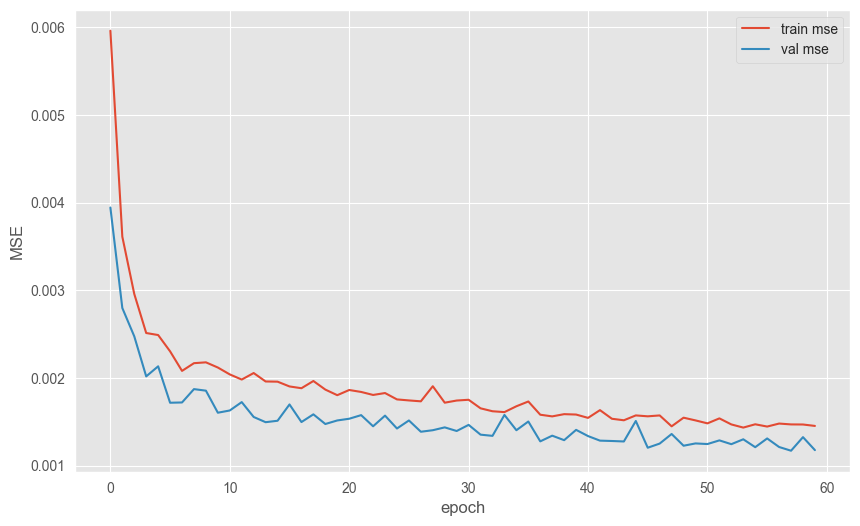

20/20 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0259    


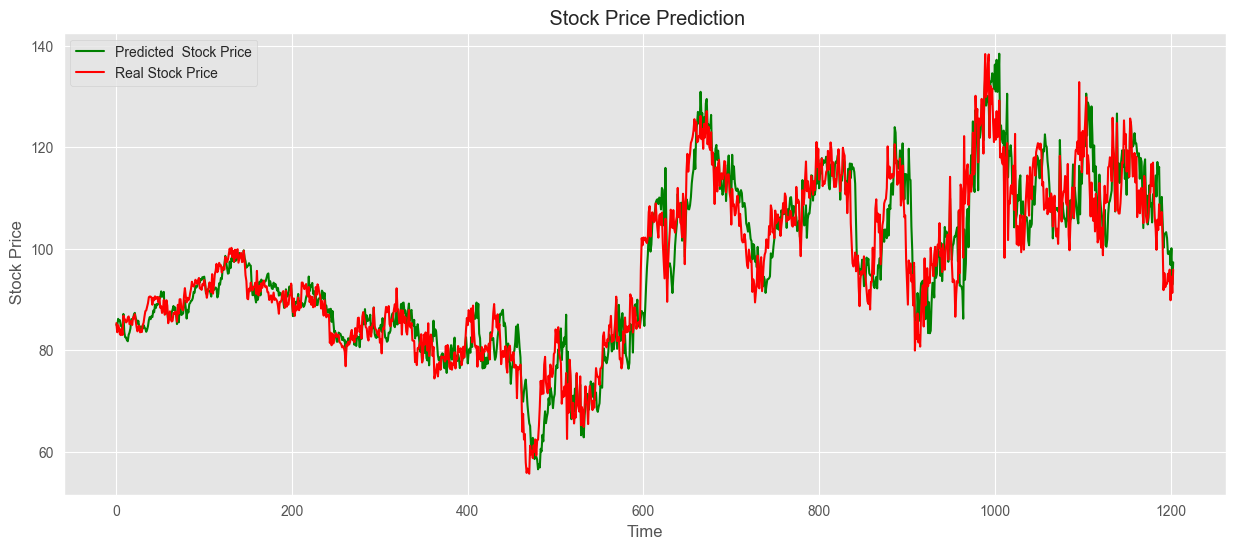

38/38 [==============================] - 0s 1ms/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0420    
Epoch 1/60
95/95 [==============================] - 2s 7ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0597 - val_loss: 0.0025 - val_mse: 0.0025 - val_mae: 0.0370
Epoch 2/60
95/95 [==============================] - 0s 4ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0402 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0326
Epoch 3/60
95/95 [==============================] - 0s 4ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0381 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0306
Epoch 4/60
95/95 [==============================] - 0s 5ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0359 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0290
Epoch 5/60
95/95 [==============================] - 0s 4ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0355 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0291
Epoch 6/60
95/95 [==============================] - 0s 4ms/step - loss: 0.0022 - mse: 0.00

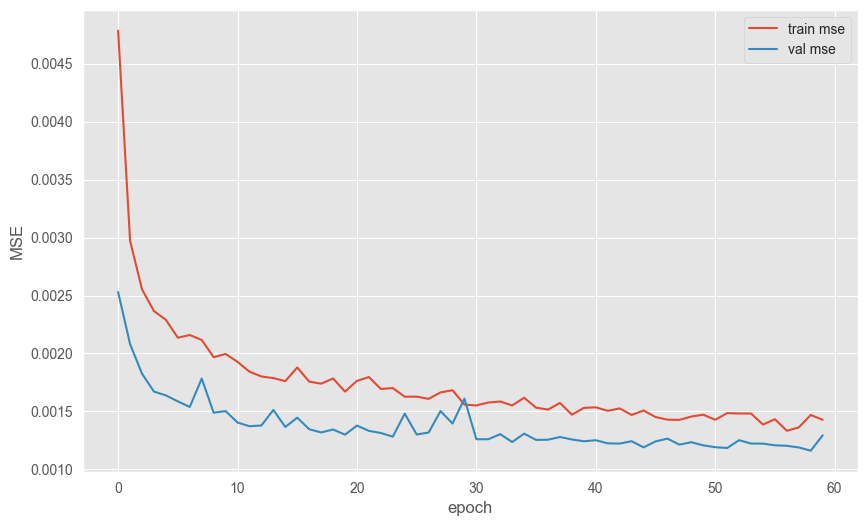

30/30 [==============================] - 0s 1ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0266    


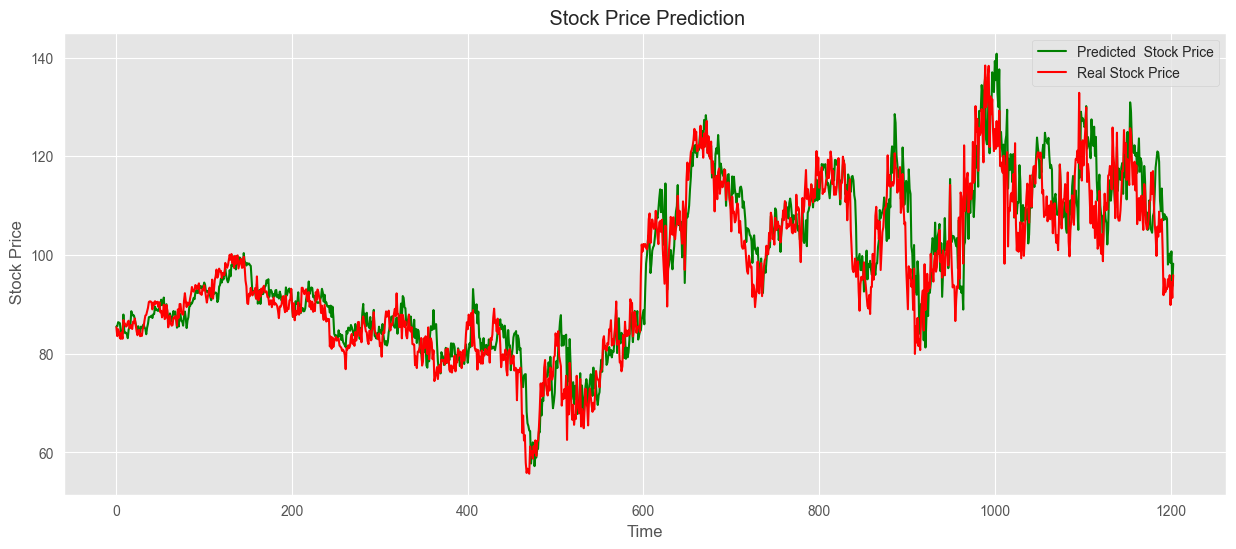

38/38 [==============================] - 0s 1ms/step - loss: 0.0033 - mse: 0.0033 - mae: 0.0426    
Epoch 1/60
87/87 [==============================] - 2s 7ms/step - loss: 0.0219 - mse: 0.0219 - mae: 0.1015 - val_loss: 0.0079 - val_mse: 0.0079 - val_mae: 0.0632
Epoch 2/60
87/87 [==============================] - 0s 5ms/step - loss: 0.0100 - mse: 0.0100 - mae: 0.0703 - val_loss: 0.0057 - val_mse: 0.0057 - val_mae: 0.0531
Epoch 3/60
87/87 [==============================] - 0s 5ms/step - loss: 0.0077 - mse: 0.0077 - mae: 0.0617 - val_loss: 0.0049 - val_mse: 0.0049 - val_mae: 0.0511
Epoch 4/60
87/87 [==============================] - 0s 5ms/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0580 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0511
Epoch 5/60
87/87 [==============================] - 0s 5ms/step - loss: 0.0069 - mse: 0.0069 - mae: 0.0575 - val_loss: 0.0051 - val_mse: 0.0051 - val_mae: 0.0516
Epoch 6/60
87/87 [==============================] - 0s 5ms/step - loss: 0.0067 - mse: 0.00

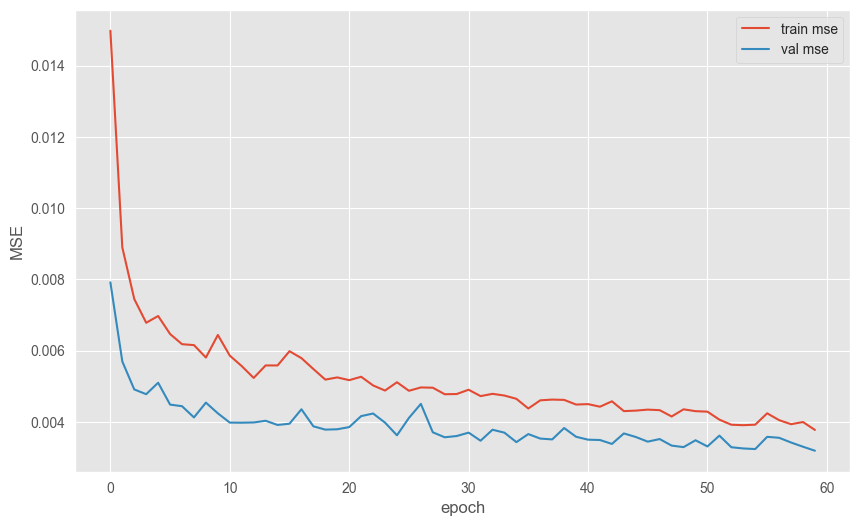

28/28 [==============================] - 0s 1ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0407


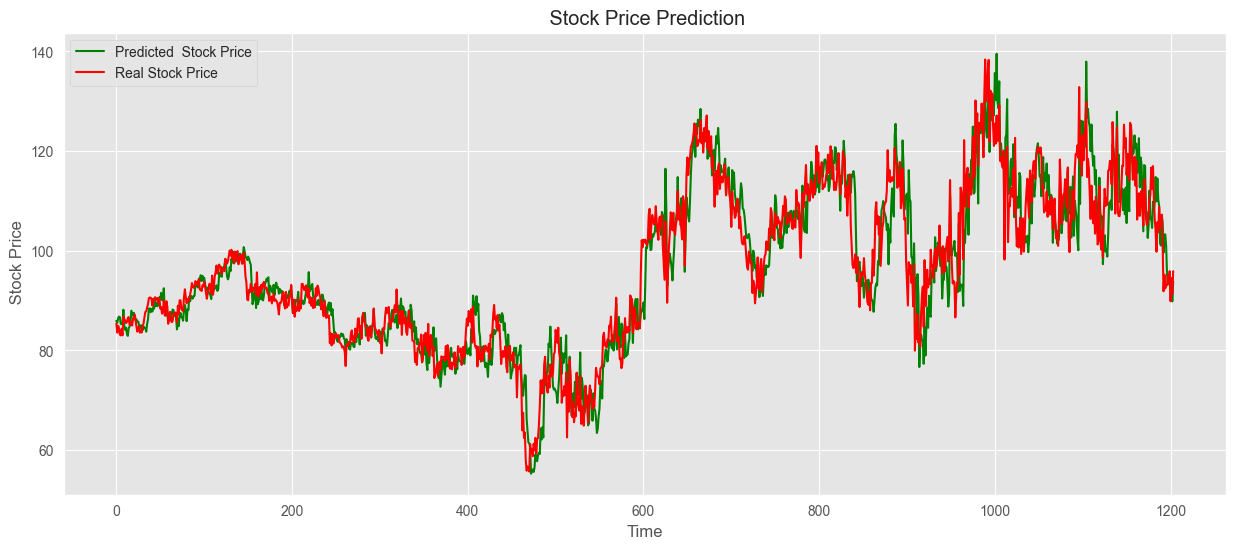

38/38 [==============================] - 0s 1ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0394    
Epoch 1/60
87/87 [==============================] - 2s 7ms/step - loss: 0.0370 - mse: 0.0370 - mae: 0.1150 - val_loss: 0.0130 - val_mse: 0.0130 - val_mae: 0.0754
Epoch 2/60
87/87 [==============================] - 0s 5ms/step - loss: 0.0169 - mse: 0.0169 - mae: 0.0829 - val_loss: 0.0109 - val_mse: 0.0109 - val_mae: 0.0686
Epoch 3/60
87/87 [==============================] - 0s 5ms/step - loss: 0.0138 - mse: 0.0138 - mae: 0.0760 - val_loss: 0.0087 - val_mse: 0.0087 - val_mae: 0.0595
Epoch 4/60
87/87 [==============================] - 0s 5ms/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0696 - val_loss: 0.0081 - val_mse: 0.0081 - val_mae: 0.0572
Epoch 5/60
87/87 [==============================] - 0s 5ms/step - loss: 0.0113 - mse: 0.0113 - mae: 0.0690 - val_loss: 0.0078 - val_mse: 0.0078 - val_mae: 0.0554
Epoch 6/60
87/87 [==============================] - 0s 5ms/step - loss: 0.0130 - mse: 0.01

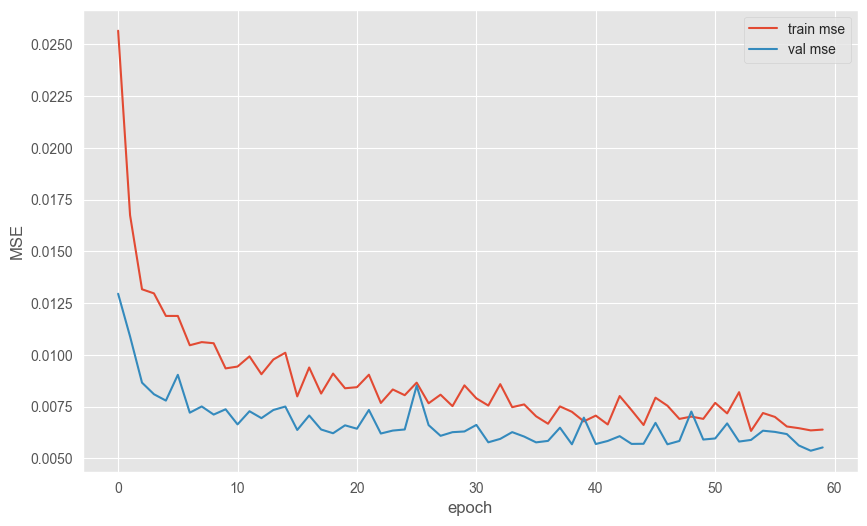

28/28 [==============================] - 0s 1ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0455


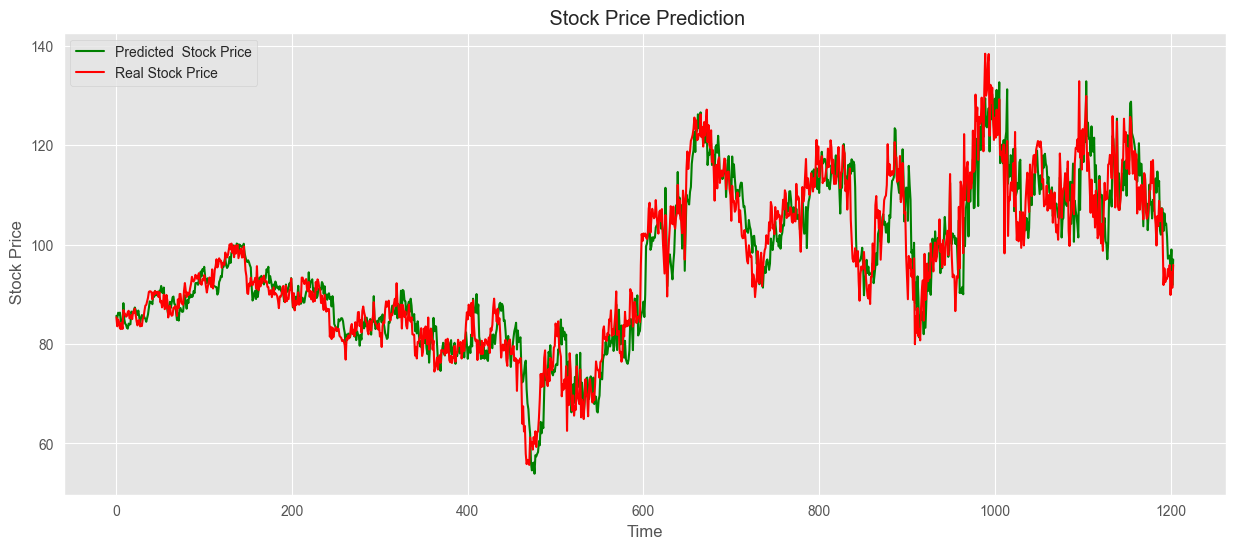

38/38 [==============================] - 0s 2ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0399   
Epoch 1/60
93/93 [==============================] - 2s 7ms/step - loss: 0.0238 - mse: 0.0238 - mae: 0.0931 - val_loss: 0.0069 - val_mse: 0.0069 - val_mae: 0.0548
Epoch 2/60
93/93 [==============================] - 0s 5ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0660 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0469
Epoch 3/60
93/93 [==============================] - 0s 5ms/step - loss: 0.0104 - mse: 0.0104 - mae: 0.0590 - val_loss: 0.0046 - val_mse: 0.0046 - val_mae: 0.0443
Epoch 4/60
93/93 [==============================] - 0s 5ms/step - loss: 0.0103 - mse: 0.0103 - mae: 0.0566 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0414
Epoch 5/60
93/93 [==============================] - 0s 5ms/step - loss: 0.0079 - mse: 0.0079 - mae: 0.0536 - val_loss: 0.0041 - val_mse: 0.0041 - val_mae: 0.0426
Epoch 6/60
93/93 [==============================] - 0s 5ms/step - loss: 0.0083 - mse: 0.008

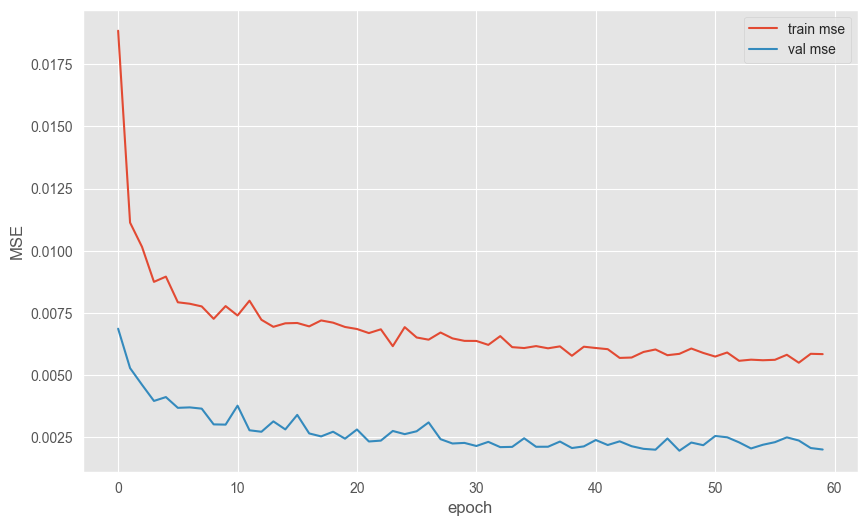

29/29 [==============================] - 0s 1ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0344


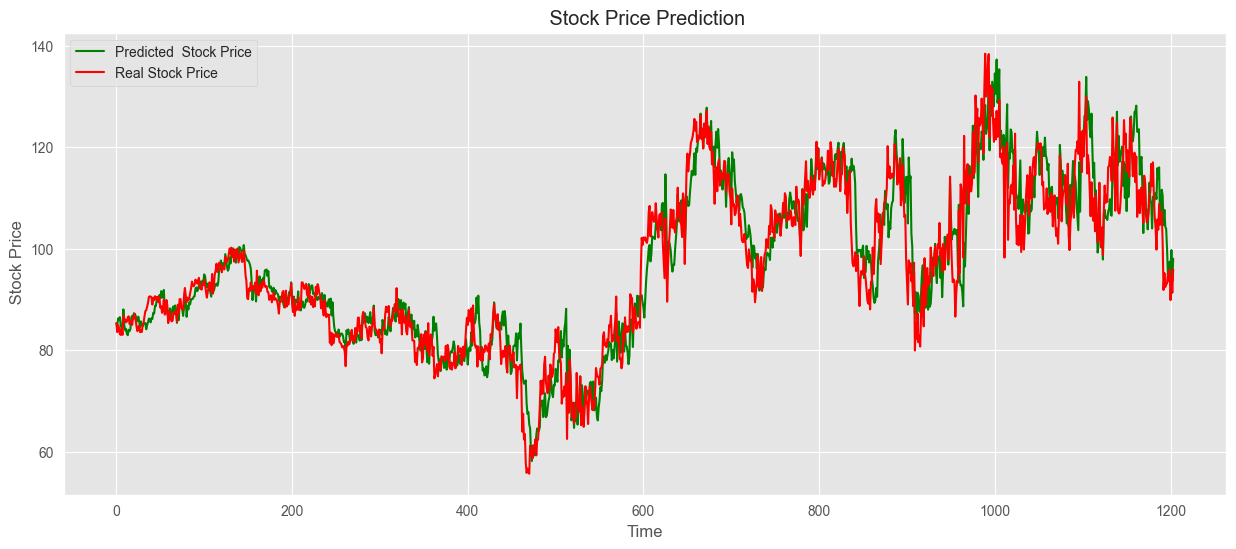

38/38 [==============================] - 0s 2ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0402   


In [154]:
data_paths = ["data/NASDAQ/abe.us.txt","data/data_LON.csv", "data/data_SHH.csv", "data/data_SHZ.csv","data/data_BSE.csv"] 
train_mse = []
test_mes = []
for data_path in data_paths:
    stock = StockPredictor(data_path,window_size=50)
    stock.fit(epochs=60)
    stock.plot()
    train_mse.append(stock.evaluate()[1])
    test_mes.append(stock.predict_others('./data/data.csv')[1])
    stock.save('model/' + data_path.split('.')[0].split('/')[1] + '.h5')

# MSE

In [155]:
# print(train_mse)
# 以保留四位小数打印
print(np.round(train_mse, 5))
print(np.round(np.mean(train_mse),5))

[0.00118 0.00129 0.00319 0.00553 0.00201]
0.00264


In [156]:
# print(test_mes)
# 以保留四位小数打印
print(np.round(test_mes, 5))
print(np.round(np.mean(test_mes),5))

[0.00331 0.0033  0.00286 0.00294 0.00306]
0.00309
